# Introduction
The primary objective of this lab is to familiarise you with the basic mechanics that allow you to get hold of satellite data for the purposes of carrying out machine learning. The second objective is for you to put into practice some of the theory that we covered in lecture 1, in order that you can start to understand some of the specific quirks and potentially powerful attributes of satellite data when it comes to applying machine learning techniques.

This lab has drawn upon the following sources, tutorials and repos:


*   https://geemap.org/
*   https://developers.google.com/earth-engine

Whenever you see a numbered question, e.g. '(1)', make sure that you answer it in the answer proforma and submit the resulting document on Canvas. Only submit in .docx or .pdf formats (we cannot open 'pages' etc docs on Canvas).

Some of the questions will be relatively simple and are designed to get you thinking about the nature of the code and what it is doing, whilst also requiring you to pull in theoretical knowledge from the lectures. Other questions are exercises that ask you to both apply this knowledege to a new challenge and/or require you to independently go and seek answers.

In all cases I encourage you to give it a go, even if you do not have the full answer. Particularly for the larger challenges ('Exercises'), marks are awarded for workings and I want to see your thought process in action via the code you write.

Use text comments as demonstrated in these lab instructions to explain your thinking and communicate with the person marking your work.

I use both comments above chunks of code to tell you the overall objectives of that code, and inline comments to highlight specific features and elements to be aware of (formatted like this to draw your attention '#<-').

# Set up

In [1]:
# Set up GEE API
import ee
ee.Authenticate()
ee.Initialize(project='earthengine-ml-testing')

In [ ]:
# Install the geemap package (only needs to be run once, uncomment below and run it the first time you run this notebook in a session).
# !pip install geemap

In [5]:
import geemap

# Loading a map and displaying satellite data

In [ ]:
# Use the built in functions to load an ipyleaflet basemap (aka a UI to explore and see what we are doing)
Map = geemap.Map(center=(-41, 172), zoom=4)
Map

In [42]:
# Specify a different kind of basemap to display data layers over
Map = geemap.Map(center=(-41, 172), zoom=4) #<- note the lat-lon coordinate pair here
Map.add_basemap("HYBRID")
Map

Map(center=[-41, 172], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

(1) Find and add the basemap 'OpenTopoMap' to the display window AND change the code so that the map opens and zooms to the city of Auckland.
Provide a screenshot of your code and the output. (2 pts)

In [48]:
# Add Earth Engine datasets to our map by first creating variables to hold the calls to the EE api
Map = geemap.Map(center=(-41, 172), zoom=4)
dem = ee.Image("USGS/SRTMGL1_003")
landcover = ee.Image("ESA/GLOBCOVER_L4_200901_200912_V2_3").select("landcover")
landsat7 = ee.Image("LANDSAT/LE7_TOA_5YEAR/1999_2003")
states = ee.FeatureCollection("TIGER/2018/States")

In [49]:
# Set visualization parameters.
vis_params = {
    "min": 0,
    "max": 4000, #<- if your satellite image is all white or all black, these vis params are the first thing to check and change
    "palette": ["006633", "E5FFCC", "662A00", "D8D8D8", "F5F5F5"], #<- these are HTML colour codes
}

In [50]:
# Add a variety of different Earth Engine layers to the Map object
Map.addLayer(dem, vis_params, "SRTM DEM", True, 0.5) #<- note vis params called from the dictionary we set up before
Map.addLayer(landcover, {}, "Land cover")
Map.addLayer(
    landsat7, {"bands": ["B4", "B3", "B2"], "min": 20, "max": 200}, "Landsat 7" #<- note vis params in a dictionary here inside the add layer call
)
Map.addLayer(states, {}, "US States")

In [51]:
# Dump all of this into the map view and take a look...
Map

Map(center=[-41, 172], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

(2) The Landsat 7 data displays as red colored/tinged image. Why is this? [Think about both the content in Lecture 1, and what is going on when you visualize a satellite image]. (2 pts)

(3) Correct the display of the Landsat 7 image so that it displays in '[True Colour](https://ie.unc.edu/wp-content/uploads/sites/277/2014/12/How-Satellite-images-are-different-from-photographs.pdf)'. Provide a screenshot of your code and the corrected output over the whole of New Zealand. (10 pts)

# Spectral reflectance curves
Next we we will generate a spectral reflectance curve for a given area.
This is a useful tool when you are considering if a given target has spectral characteristics for identification in ML. If everything has the same spectral signature, then you need to take a different approach to a simple spectral classification, as might have been the first instinct of a classical remote sensing scientist.

In [52]:
# Add in a library for plotting the data we extract
import matplotlib.pyplot as plt

In [53]:
# Define a point and a small rectangular region around it
point = ee.Geometry.Point([174.7633, -36.8485])  # Auckland, NZ
region = point.buffer(150).bounds()  # ~300 m box

In [54]:
# Load a Landsat 7 Collection 2 Level 2 SR image (surface reflectance)
image = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filterBounds(region) \
    .filterDate('2002-01-01', '2002-12-31') \
    .sort('CLOUD_COVER') \
    .first()

(4) Why are we using the surface reflectance (SR) here rather than the top of atmosphere (ToA)? (2 pt)

In [55]:
# Select surface reflectance bands and apply scale factor
bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']
band_names = {
    'SR_B1': 'Blue (0.45–0.52 μm)',
    'SR_B2': 'Green (0.52–0.60 μm)',
    'SR_B3': 'Red (0.63–0.69 μm)',
    'SR_B4': 'NIR (0.77–0.90 μm)',
    'SR_B5': 'SWIR1 (1.55–1.75 μm)',
    'SR_B7': 'SWIR2 (2.09–2.35 μm)'
}

scale_factor = 2.75e-5  # From USGS documentation for Landsat C2 L2

(5) What is a 'scale factor' as has been used in the prior code cell, and why are they used in satellite data storage-to-processing workflows such as this? (2 pts)

**Important sidenote**

The 'reduce' operation is a key concept in the backend of how Google is storing and serving us large quanities of satellite data. GEE uses 'reducers' in multiple ways, many of which are not always immediately intuitive. Check out the docs for more information:

*   https://developers.google.com/earth-engine/guides/reducers_intro

Here we are using a reduce operation over the specified small sample area in order to find the mean of all the cells that lie within the region:

In [56]:
# Reduce region to mean reflectance
mean_dict = image.select(bands).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=30,
    maxPixels=1e6
)

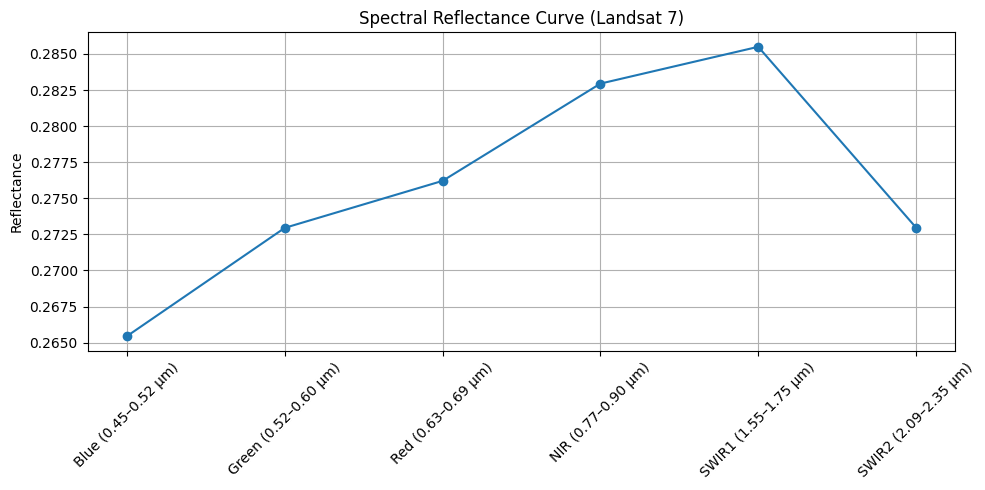

In [57]:
# Extract and scale values
mean_values = mean_dict.getInfo()
reflectance = [mean_values[b] * scale_factor for b in bands]

# Plot the spectral curve
plt.figure(figsize=(10, 5))
plt.plot(list(band_names.values()), reflectance, marker='o', linestyle='-')
plt.title('Spectral Reflectance Curve (Landsat 7)')
plt.ylabel('Reflectance')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

(6) If we want to apply multiple reducers to the same inputs what is a more efficient way to do so than just writing out a long series of sequential reducers on our end? (2 pts)

# Cloud cover
A final consideration that I want to cover in this lab is that of cloud cover. Cloud cover removal is a complex and often difficut process that GISCI 341 students spend an entire two weeks tackling as a focus (so use them in your teams!). However, for our purpose here lets just use the basic in-built cloud clearing native to the Landsat 7 collection on GEE.

In [58]:
# Define small region around Auckland, NZ
point = ee.Geometry.Point([174.7633, -36.8485])
region = point.buffer(500).bounds()

# Load the image with least cloud cover in 2002
image = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
    .filterBounds(region) \
    .filterDate("2002-01-01", "2002-12-31") \
    .sort("CLOUD_COVER") \
    .first() #<- note the filtering step that is being applied here! We are taking the first image in a sorted by cloud cover response.

# Check metadata
print('Image ID:', image.get('LANDSAT_PRODUCT_ID').getInfo())
print('Cloud Cover (whole scene):', image.get('CLOUD_COVER').getInfo())

Image ID: LE07_L2SP_073086_20020827_20200916_02_T1
Cloud Cover (whole scene): 1


In [59]:
# Function to mask clouds using QA_PIXEL band
def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    # Bits 3 and 4 are cloud and cloud shadow respectively
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0).And(
                 qa.bitwiseAnd(1 << 4).eq(0))
    return image.updateMask(cloud_mask)

# Apply mask
masked_image = mask_clouds(image)

**Important side note**

In the function above we are using a bitwise operation in order to search through the quality assurance (QA) band of the image. Different satellites have different bit-masks. Read more about bitmasks and how they are used here:
*   https://spatialthoughts.com/2021/08/19/qa-bands-bitmasks-gee/



**Another important side note**

You will have noticed that we are frequently running code and not seeing anything happen in terms of output in the cell or changes in the RAM/Disk of the Colab instance (check the small graphs top right). This is deliberate! Satellite data is large and hard to wrangle. GEE does a lot of the work for us, hence we can explore and get into it so quickly. Part of how it does this is by not executing any of your API calls until you specifically ask for an output to be sent back to you. Prior to calling an output (usually through a 'AddLayer' or similar call), when using the GEE/EE API you are essentially chaining together a lot of dot-operators (e.g. '.sort \ .reduce') into a series of instructions that are verified, but only then acted on when required.

This is the result of a 'client vs. server' approach. For more detail, that will help you understand why you can and cannot do certain things, see:
*   https://developers.google.com/earth-engine/guides/client_server



In [60]:
# Report Image Quality Over ROI
# Total pixels in region
pixel_area = ee.Image.pixelArea().clip(region)

# Count valid pixels before and after masking
total_pixels = pixel_area.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=region,
    scale=30,
    maxPixels=1e9
).getInfo()['area']

valid_pixels = masked_image.select('SR_B3').reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=region,
    scale=30,
    maxPixels=1e9
).getInfo()['SR_B3']

cloud_coverage_pct = 100 * (1 - valid_pixels / total_pixels)

print(f"Total Pixels: {total_pixels}")
print(f"Valid (non-cloud) Pixels: {valid_pixels}")
print(f"Estimated Cloud Coverage in ROI: {cloud_coverage_pct:.2f}%")

Total Pixels: 1394
Valid (non-cloud) Pixels: 1050
Estimated Cloud Coverage in ROI: 24.68%


In [61]:
# Visualize the before and after
Map = geemap.Map(center=[-36.8485, 174.7633], zoom=12)

vis = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
    'min': 0,
    'max': 30000,
    'gamma': 1.4
}

Map.addLayer(image, vis, 'Original Image (Cloudy)')
Map.addLayer(masked_image, vis, 'Cloud Masked')
Map

Map(center=[-36.8485, 174.7633], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

(7) Produce a table that summarises the amount of cloud cover per year (as a percentage) for 2005, 2010 and 2015 over a region of your choice. Provide a screenshot of your code that does so in addition to your table. (5 pts)

# Final exercise
Let us now be very fancy and plot our spectral reflectance curve along with a display of the satellite data that it was generated from. As well as being fancy, this lets us see that what we have done here is sample the urban fabric of downtown Auckland and collect the spectral signature of 'urban'.

The code block below is large and calls in some further packages as we start to push beyond what is already built into geemap. I have also placed all the required code in one cell as I am about to ask you to do something with it... Make sure that you take the time understand what each section is doing and why. Consider starting to break this code down into functions that you can re-use later.

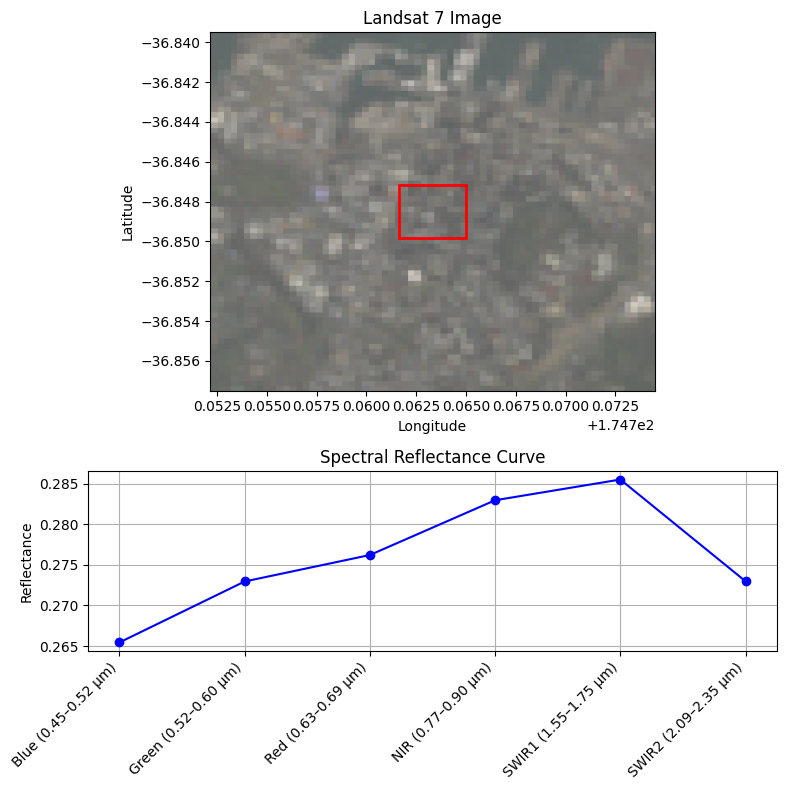

In [72]:
# Additional required packages
import matplotlib.patches as patches
import urllib.request
import tempfile
import matplotlib.image as mpimg

# Define point and regions
point = ee.Geometry.Point([174.7633, -36.8485])
region = point.buffer(150).bounds()        # ~300 m box
expanded_region = point.buffer(1000).bounds()  # box for image preview

# Load Landsat 7 surface reflectance image
image = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filterBounds(region) \
    .filterDate('2002-01-01', '2002-12-31') \
    .sort('CLOUD_COVER') \
    .first()

# Define bands and scaling
bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']
band_names = {
    'SR_B1': 'Blue (0.45–0.52 μm)',
    'SR_B2': 'Green (0.52–0.60 μm)',
    'SR_B3': 'Red (0.63–0.69 μm)',
    'SR_B4': 'NIR (0.77–0.90 μm)',
    'SR_B5': 'SWIR1 (1.55–1.75 μm)',
    'SR_B7': 'SWIR2 (2.09–2.35 μm)'
}
scale_factor = 2.75e-5

# Calculate mean reflectance
mean_dict = image.select(bands).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=30,
    maxPixels=1e6).getInfo()

reflectance = [mean_dict[b] * scale_factor for b in bands]
labels = list(band_names.values())

# Get RGB thumbnail slightly zoomed out
thumb_params = {
    'dimensions': 512,
    'region': expanded_region,
    'format': 'png',
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
    'min': 0,
    'max': 30000,
    'gamma': 1.4
}
url = image.getThumbURL(thumb_params)

# Get coordinates of regions
def get_bounds_coords(bounds):
    coords = bounds.coordinates().getInfo()[0]
    lons = [pt[0] for pt in coords]
    lats = [pt[1] for pt in coords]
    return min(lons), max(lons), min(lats), max(lats)

# Extract bounding boxes
xmin, xmax, ymin, ymax = get_bounds_coords(expanded_region)
rxmin, rxmax, rymin, rymax = get_bounds_coords(region)

# Plot both panels
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})

# Load and plot image with annotation
with tempfile.NamedTemporaryFile(suffix=".png") as f:
    urllib.request.urlretrieve(url, f.name)
    img = mpimg.imread(f.name)
    ax1.imshow(img, extent=[xmin, xmax, ymin, ymax])
    ax1.set_title("Landsat 7 Image")
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)

    # Add red rectangle for region of interest
    width = rxmax - rxmin
    height = rymax - rymin
    rect = patches.Rectangle((rxmin, rymin), width, height,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax1.add_patch(rect)
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")

# Plot reflectance
ax2.plot(labels, reflectance, marker='o', color='blue')
ax2.set_title("Spectral Reflectance Curve")
ax2.set_ylabel("Reflectance")
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.grid(True)

plt.tight_layout()
plt.show()


(8) Using Sentinel 2, create a figure that does the following over the city of Christchurch, NZ:
*   Conduct a basic quality assessment of the data you use, using a cloudy pixel % estimate.
* Describe/show the spectral reflectance signatures of: urban, forest, grassland, water and bare soil.
* Illustrates the sample areas that you have used to create these spectral signatures.

Provide a publication quality copy of this figure in the answer proforma. Publication quality means that:  
1.   It is at a good quality (resolution) and not blurry.
2.   The font size of all elements is big enough to read easily on a screen when placed in the document.
3. Has a figure caption that ensures the reader knows what you have done and why.
4. Tells the story 'at a glance'. Don't make your viewer work too hard to understand your core message.

(25 pts)


